In [1]:
!pip install openai
!pip install lckr_jupyterlab_variableinspector


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
from openai.types.beta.threads import ImageFileContentBlock

In [3]:
import os
API_KEY = os.environ["OPENAI_API_KEY"]

In [4]:
from openai import OpenAI


client = OpenAI(api_key=API_KEY)

assistant = client.beta.assistants.create(
  instructions="""
      You are an AI assistant that will allow users to talk to 
      their data-rich models. In the responses where you're running code, 
      do not provide any additional response besides the code and the output 
      of the code, and also always run the code.I will provide you with json files 
      that contain data that were either made from Speckle or from IfcOpenShell and 
      you need to be able to read this data and perform analysis on it.You will need 
      to extract the properties and attributes from the various objects that are 
      provided to learn about them and what can be analysed about them.
      """,
  model="gpt-4o-2024-05-13",
  tools=[{"type": "code_interpreter"}]
)

In [5]:
file = client.files.create(
  file=open("static/test_files/MEP_OLVG_test.json", "rb"),
  purpose='assistants'
)

In [6]:
thread = client.beta.threads.create(
  messages=[
    {
      "role": "user",
      "content": "Here's a model with some data as a Speckle json.",
      "attachments": [
        {
          "file_id": file.id,
          "tools": [{"type": "code_interpreter"}]
        }
      ]
    }
  ]
)

In [7]:
from typing_extensions import override
from openai import AssistantEventHandler

# First, we create a EventHandler class to define
# how we want to handle the events in the response stream.

class EventHandler(AssistantEventHandler):
  @override
  def on_text_created(self, text) -> None:
    print(f"\nassistant > ", end="", flush=True)

  @override
  def on_text_delta(self, delta, snapshot):
    print(delta.value, end="", flush=True)

  def on_tool_call_created(self, tool_call):
    print(f"\nassistant > {tool_call.type}\n", flush=True)

  def on_tool_call_delta(self, delta, snapshot):
    if delta.type == 'code_interpreter':
      if delta.code_interpreter.input:
        print(delta.code_interpreter.input, end="", flush=True)
      if delta.code_interpreter.outputs:
        print(f"\n\noutput >", flush=True)
        for output in delta.code_interpreter.outputs:
          if output.type == "logs":
            print(f"\n{output.logs}", flush=True)

In [8]:
with client.beta.threads.runs.stream(
  thread_id=thread.id,
  assistant_id=assistant.id,
  instructions="Provide me with some sort of cool visualisation for the various types of elements that are present in the building.",
  event_handler=EventHandler(),
) as stream:
  stream.until_done()


assistant > Great! You have uploaded a Speckle JSON file. I’ll take a look at its content and then create an appropriate visualization involving the elements present in the building.

Let's first load and inspect the contents of your file.
assistant > code_interpreter

import json

# Load the JSON file
file_path = '/mnt/data/file-QvR0gQpSVCA5IWdF8pXxS6Ma'
with open(file_path, 'r') as file:
    speckle_data = json.load(file)

# Inspect the data structure by looking at the keys and some sample data
keys = list(speckle_data.keys())
sample_data = speckle_data[keys[0]]

keys, sample_data
assistant > The JSON file contains the following top-level keys:
- `id`
- `speckle_type`
- `totalChildrenCount`
- `applicationId`
- `elements`
- `units`

The most relevant key for visualizing the elements in the building is likely the `elements` key. Let’s dig into the `elements` key to see what types of elements are present and how they are structured.# Extract and inspect the 'elements' key
elements = sp

In [9]:
messages = client.beta.threads.messages.list(thread_id=thread.id)

In [10]:
from pathlib import Path
from IPython.display import Image, display, Markdown

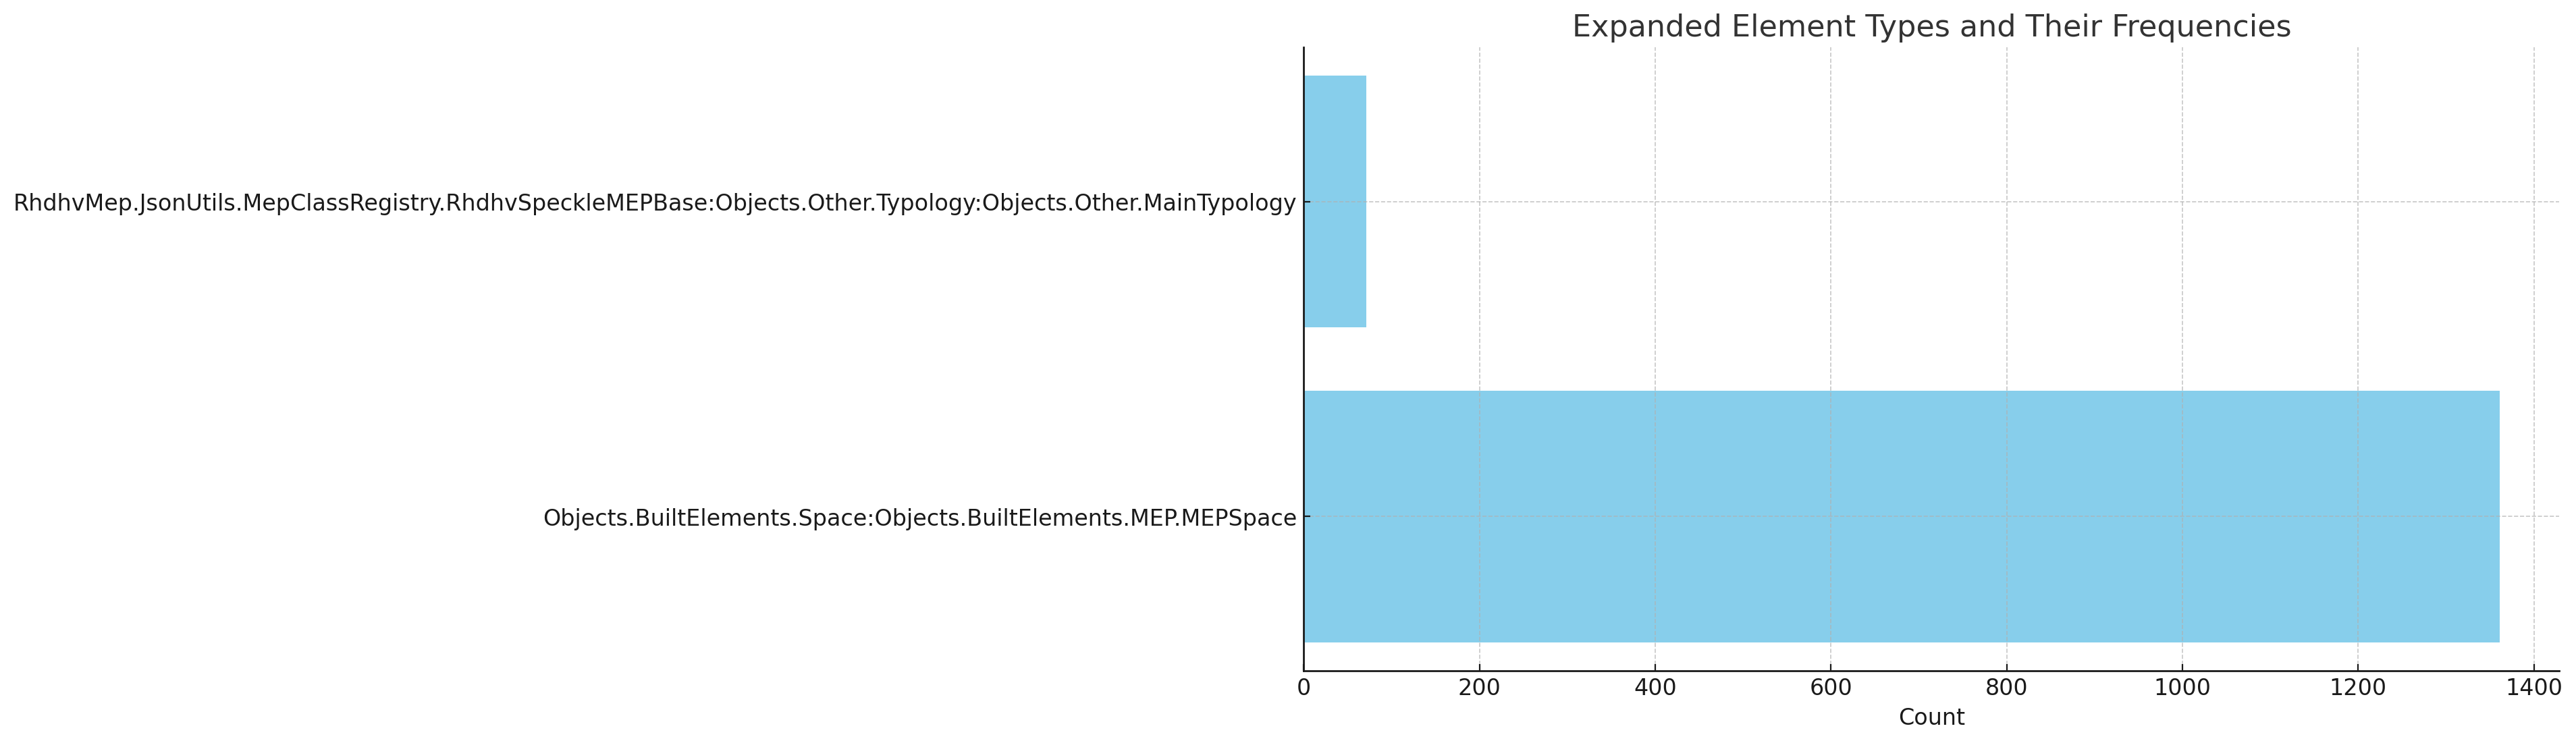

The expanded bar plot reveals more variety in the element types and their frequencies within the building.

Here, we can observe multiple types of elements and their counts:

- `RhdhvMep.JsonUtils.MepClassRegistry.RhdhvSpeckleMEPBase:Objects.Other.Typology:Objects.Other.MainTypology`
- `Objects.BuiltElements.Space:Objects.BuiltElements.MEP.MEPSpace`

These results indicate the presence of multiple categories within the nested elements.

To summarize:
- We have two distinct speckle types: one type is related to "Main Typology" and another to "MEPSpace".
- The majority of elements fall under the "MEPSpace" category.

If you need more refined or specific visualizations, suggest additional data points or attributes you'd like to explore!

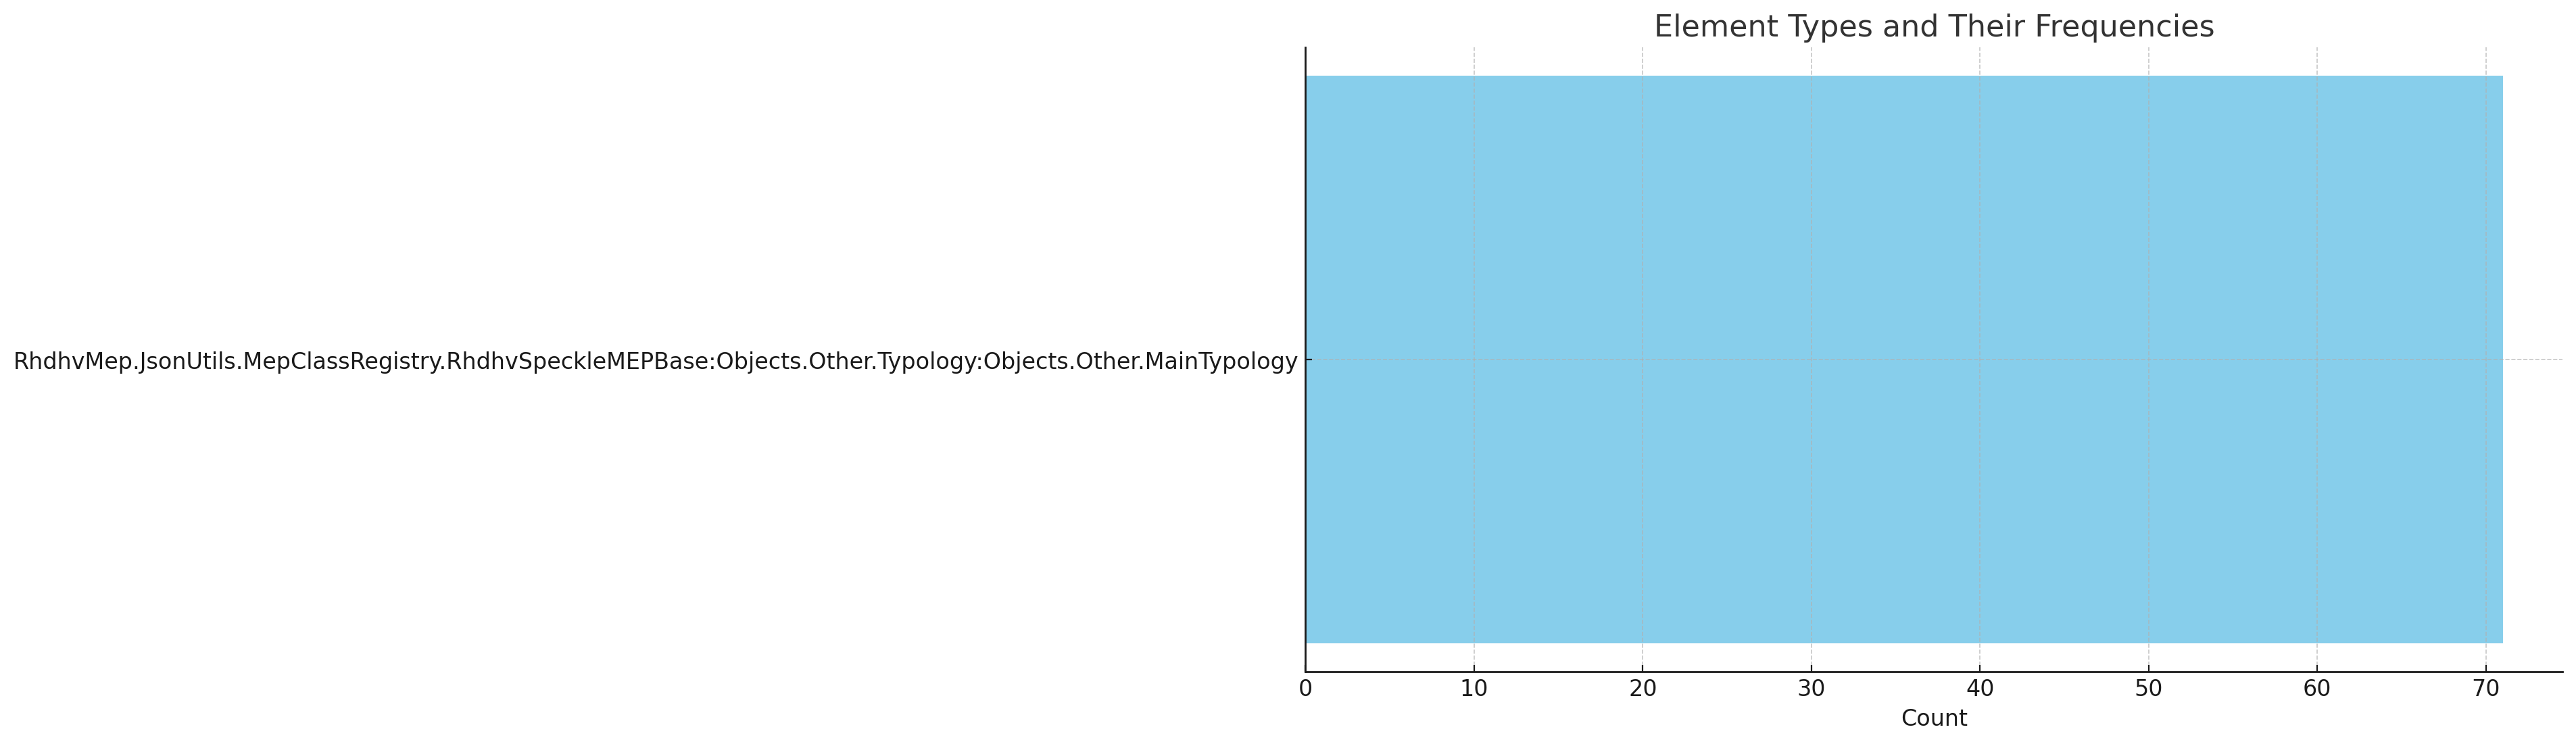

The bar plot above shows the types of elements and their counts extracted from the sample data. Currently, we see that there's only one type listed, suggesting we either need to inspect more elements or break down further if there are sub-categories within such a type.

Since we're working with nested elements, let's explore more categories or details from the other parent elements to see if we can enhance this visualization with broader categories.

The first element with the name "Typologies" is a collection of nested elements, each representing a distinct typology with its own id, name, and speckle_type.

For visualization purposes, it will be useful to extract the types of elements and their counts in the building. We'll create a summary chart of the element types and their frequencies.

Let's move forward with this plan.

It looks like each element contains a variety of nested data, including keys such as:
- `id`
- `speckle_type`
- `totalChildrenCount`
- `applicationId`
- `collectionType`
- `elements` (which seems to be a nested list of elements)
- `name`
- `units`

Let's dig a bit deeper into one of these elements to better understand its structure and identify useful attributes for visualization.

It seems the elements data might be too large for a straightforward direct inspection. Let's narrow down what we inspect by focusing on a smaller subset of elements. We'll check the types and key attributes of only a few elements for now.

The JSON file contains the following top-level keys:
- `id`
- `speckle_type`
- `totalChildrenCount`
- `applicationId`
- `elements`
- `units`

The most relevant key for visualizing the elements in the building is likely the `elements` key. Let’s dig into the `elements` key to see what types of elements are present and how they are structured.

Great! You have uploaded a Speckle JSON file. I’ll take a look at its content and then create an appropriate visualization involving the elements present in the building.

Let's first load and inspect the contents of your file.

Here's a model with some data as a Speckle json.

In [11]:
file_ids = []
new_messages = []
image_id = 0
temp_path = Path.cwd() / 'temp'
temp_path.mkdir(exist_ok=True, parents=True)
for msg in messages.data:
  for cont in msg.content:
        if isinstance(cont, ImageFileContentBlock):
            image_id += 1
            img_response = client.files.with_raw_response.retrieve_content(cont.image_file.file_id)
            content = img_response.content
            new_messages.append({"type": "img", "value": content})
            with open(f'temp/image_{image_id}.png', 'wb') as f:
                f.write(content)
                display(Image(filename=f'temp/image_{image_id}.png'))
        else:
            new_messages.append({"type": "text", "value": cont.text.value})
            display(Markdown(cont.text.value))


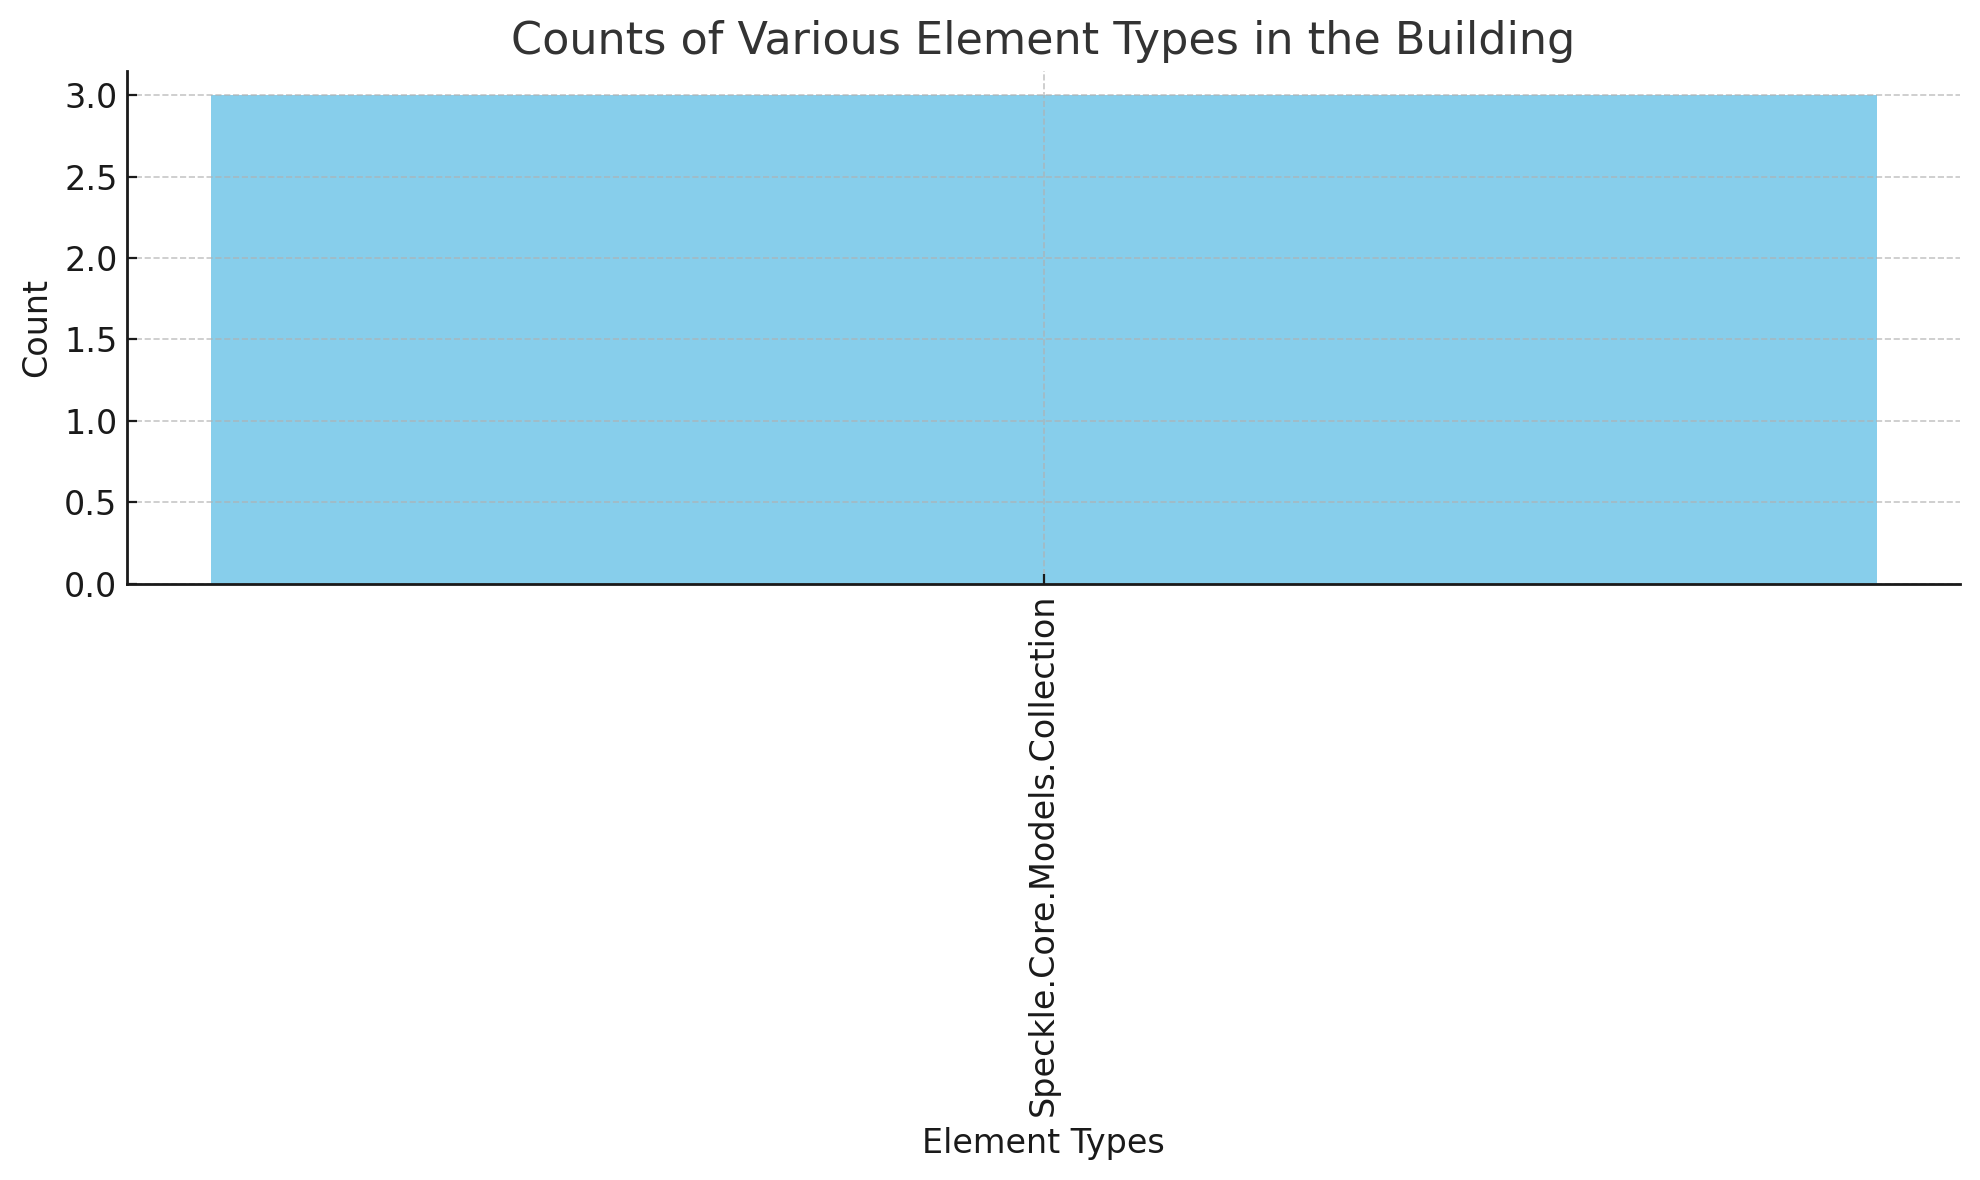

In [35]:
%reset -f